In [1]:
from blitz_env.simulate_draft_sqlite import init_database
init_database(2025)

### Datasette

Datasette is a sqlite visual explorer.  `make launch-simulator` should have already kicked off an instance running at [http://127.0.0.1:8001/](http://127.0.0.1:8001/).  

If not, you can run an instance from terminal with `datasette gamestate.db`

## Pandas

Here is some helper code for exploring the data with pandas

In [4]:
from blitz_env.models import DatabaseManager
import pandas as pd

db = DatabaseManager()
preason_df = pd.read_sql("SELECT * FROM season_stats", db.engine) # get game status
# preason_df.to_csv("season_stats.csv", index=False)

# 17240 == Saquon Barkley FantasyPros

preason_df = pd.read_sql("SELECT * FROM season_stats where fantasypros_id = '17240'", db.engine) # get game status
preason_df

,index,year,week,fantasypros_id,player_name,position,team,pos_rank,RUSHING_ATT,RUSHING_YDS,...,FGA,PCT,LG,1-19,20-29,30-39,40-49,50+,XPT,XPA
0,0,2024,,17240,Saquon Barkley,RB,PHI,1,345.0,2005.0,...,None,None,None,None,None,None,None,None,None,None
1,12,2023,,17240,Saquon Barkley,RB,PHI,13,247.0,962.0,...,None,None,None,None,None,None,None,None,None,None


## Example Draft

Current pick is 11
Josh Allen
Current pick is 16
Jalen Hurts
Current pick is 37
Deebo Samuel Sr.
Current pick is 42
James Cook
Current pick is 63
Chris Godwin
Current pick is 68
Jordan Love
Current pick is 89
Brian Robinson Jr.
Current pick is 94
Jared Goff
Current pick is 115
Jakobi Meyers
Current pick is 120
Jameson Williams
Current pick is 141
Baltimore Ravens
Current pick is 146
Justin Tucker


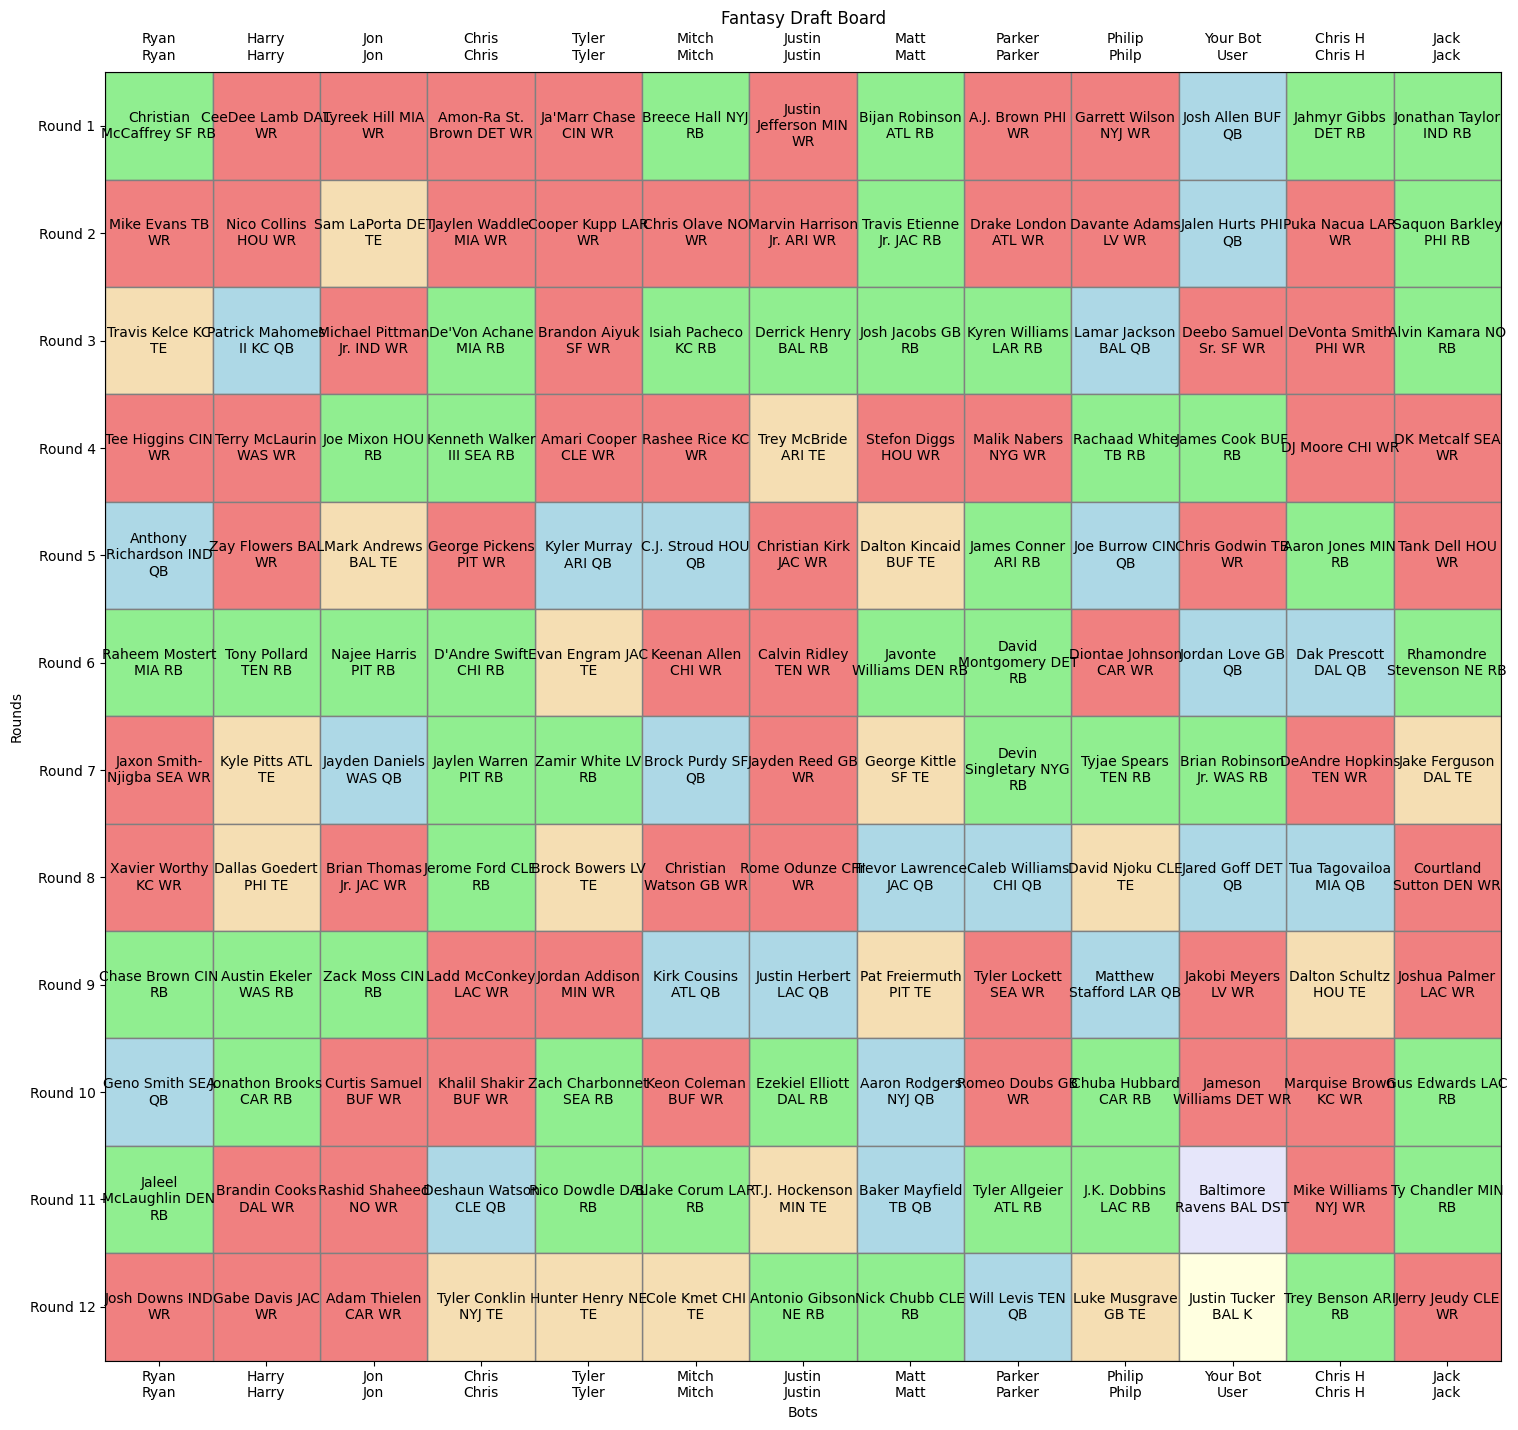

In [2]:
from blitz_env.simulate_draft_sqlite import simulate_draft, visualize_draft_board
from blitz_env.models import DatabaseManager
import pandas as pd
import json

def get_current_round(db):
    settings_df = pd.read_sql("SELECT * FROM league_settings", db.engine) # get leagueSettings
    leagueSettings = settings_df.iloc[0]
    
    status_df = pd.read_sql("SELECT * FROM game_statuses", db.engine) # get game status
    gameSettings = status_df.iloc[0]

    zero_based_round = (gameSettings["current_draft_pick"] - 1) // leagueSettings["num_teams"]
    return zero_based_round + 1

def get_pick_details(db):
    settings_df = pd.read_sql("SELECT * FROM league_settings", db.engine) # get leagueSettings
    leagueSettings = settings_df.iloc[0]
    
    status_df = pd.read_sql("SELECT * FROM game_statuses", db.engine) # get game status
    gameSettings = status_df.iloc[0]

    return gameSettings["current_draft_pick"], leagueSettings["num_teams"]

def get_total_rounds(db) -> int:
    settings_df = pd.read_sql("SELECT * FROM league_settings", db.engine) # get game status
    return settings_df.iloc[0]["total_rounds"]

def get_my_team(db):
    df = pd.read_sql("SELECT * FROM game_statuses", db.engine) # get game status
    draft_pick = df.iloc[0]["current_draft_pick"]
    print(f"Current pick is {draft_pick}")
    
    bot_id = df.iloc[0]["current_bot_id"]
    queryStr = f"SELECT * FROM players where current_bot_id = '{bot_id}'"
    my_team = pd.read_sql(queryStr, db.engine) 

    player_positions_map = {
        row["full_name"]: (json.loads(row["allowed_positions"])[0] if row["allowed_positions"] else None)
        for _, row in my_team.iterrows()
    }

    return player_positions_map

def convert_team_to_position_map(curTeam):
    positionCounts = {}
    for playerName, position in curTeam.items():
        if position in positionCounts:
            positionCounts[position] += 1
        else:
            positionCounts[position] = 1
    return positionCounts

def is_player_allowed(row, current_round, total_rounds):
    team_block_map = { 
            "CHI": "",
            "CAR": "",
            "NYJ": "",
            "NO": "",
            "IND": "",
            "CLE": "",
    }

    if current_round == total_rounds - 1:
        return any(row["allowed_positions_set"] & {"DST"}) and row["professional_team"] not in team_block_map

    if current_round == total_rounds:
        return any(row["allowed_positions_set"] & {"K"}) and row["professional_team"] not in team_block_map

    if current_round < 9 and any(row["allowed_positions_set"] & {"TE"}):
        return False
    
    allowlisted_players = {"Alvin Kamara", "Jonathan Taylor", "David Njoku"}
    if row["full_name"] in allowlisted_players:
        return True

    if row["professional_team"] in team_block_map:
        return False

    if row["professional_team"] == "JAC":
        return any(row["allowed_positions_set"] & {"RB"})

    return True

def get_eligible_available_players(db, current_round, total_rounds):
    df = pd.read_sql("SELECT * FROM players where availability = 'AVAILABLE'", db.engine)

    # expand the allowed_position json strings into a set
    df["allowed_positions_set"] = df["allowed_positions"].apply(
        lambda x: set(json.loads(x)) if x else set()
    )

    df = df[df.apply(lambda row: bool(is_player_allowed(row, current_round, total_rounds)), axis=1)]
    df = df.sort_values(by="rank", ascending=True)
    return df

def is_crazy_value(rank, current_pick, picks_per_round):
    return current_pick >= (rank + 2 * picks_per_round)

def adjust_rankings_for_qbs(db, players, current_round, current_team, current_pick, picks_per_round):
    position_counts = convert_team_to_position_map(current_team)
    
    tier1Players = {
        "Josh Allen",
        "Lamar Jackson",
        "Jayden Daniels",
        "Joe Burrow",
        "Jalen Hurts",
        "Patrick Mahomes"
    }

    tier2Players = {
        "Baker Mayfield",
        "Bo Nix",
        "Kyler Murray"
    }

    if current_round <= 2:
        players["rank"] = players.apply(lambda row: row["rank"] - 1000 if row["full_name"] in tier1Players else row["rank"], axis=1)
        players = players.sort_values(by="rank", ascending=True)
        return players
    elif current_round >= 4 and ("QB" in position_counts and position_counts["QB"] < 2) and ("RB" in position_counts and position_counts["RB"] >= 2) and ("WR" in position_counts and position_counts["WR"] >= 2):
        players["rank"] = players.apply(lambda row: row["rank"] - 1000 if (row["full_name"] in tier1Players or row["full_name"] in tier2Players) else row["rank"], axis=1)
        players = players.sort_values(by="rank", ascending=True)
        return players
    elif ("QB" in position_counts and position_counts["QB"] >= 2):
        penalty = 1000 if "RB" not in position_counts or position_counts["RB"] < 3 or "WR" not in position_counts or position_counts["WR"] < 3 else 0

        # TODO: need to add logic for seeing if there are any folks that are especially good relative to ADP
        
        players["rank"] = players.apply(lambda row: row["rank"] + penalty if any(row["allowed_positions_set"] & {"QB"}) and is_crazy_value(row["rank"], current_pick, picks_per_round) else row["rank"], axis=1)
        players = players.sort_values(by="rank", ascending=True)
        return players
    else:
        return players

def adjust_rankings_for_rbs_and_wrs(db, players, current_round, current_team):
    position_counts = convert_team_to_position_map(current_team)

    if current_round <= 7:
        if "WR" in position_counts and position_counts["WR"] >= 3:
            players["rank"] = players.apply(lambda row: row["rank"] + 1000 if any(row["allowed_positions_set"] & {"WR"}) else row["rank"], axis=1)
        elif "RB" in position_counts and position_counts["RB"] >= 3:
            players["rank"] = players.apply(lambda row: row["rank"] + 1000 if any(row["allowed_positions_set"] & {"RB"}) else row["rank"], axis=1)
    
    # TODO: ideally look for RBs with high targets for PPR
    
    return players


def draft_player() -> str:
    """
    Selects a player to draft based on the highest rank.

    Args:
        players (List[Player]): A list of Player objects.

    Returns:
        str: The id of the drafted player.
    """

    db = DatabaseManager()
    try:
        current_round = get_current_round(db)
        total_rounds = get_total_rounds(db)
        my_team = get_my_team(db)
        current_pick, picks_per_round = get_pick_details(db)

        players = get_eligible_available_players(db, current_round, total_rounds)
        players = adjust_rankings_for_qbs(db, players, current_round, my_team, current_pick, picks_per_round)
        players = adjust_rankings_for_rbs_and_wrs(db, players, current_round, my_team)

        if not players.empty:
            best_player = players.iloc[0]
            print(best_player["full_name"])
            return best_player["id"]  # No need for conditional on the Series itself
        else:
            return ""  # No eligible player
    finally:
        db.close()

# Run the draft simulation - data is stored in SQLite database
season = 2024
simulate_draft(draft_player, season)
visualize_draft_board()

Downcasting floats.


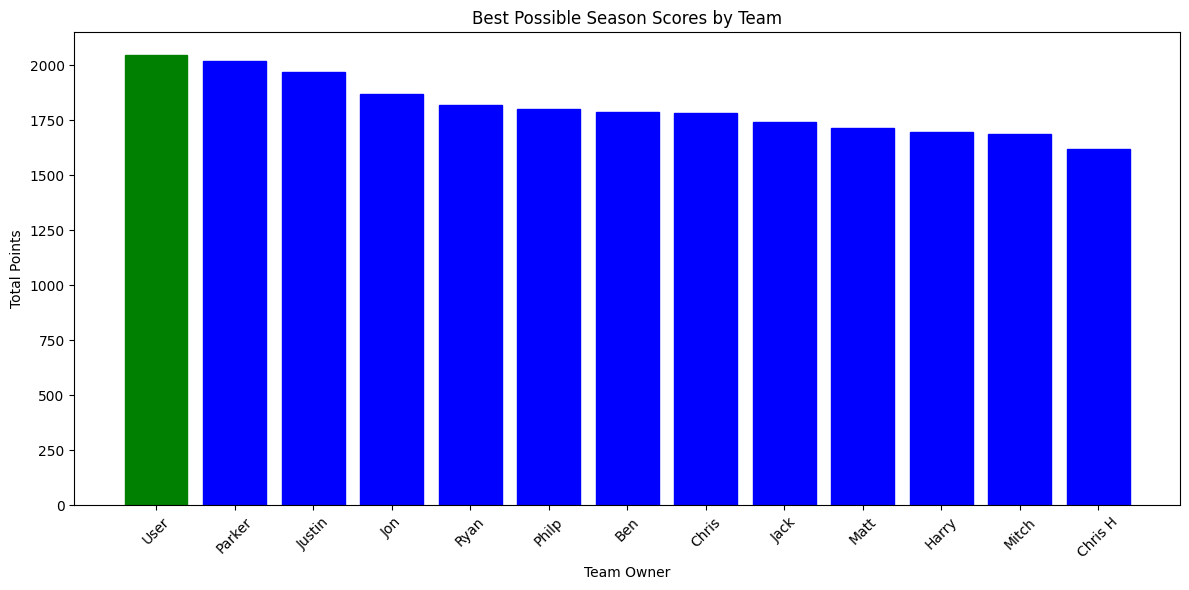

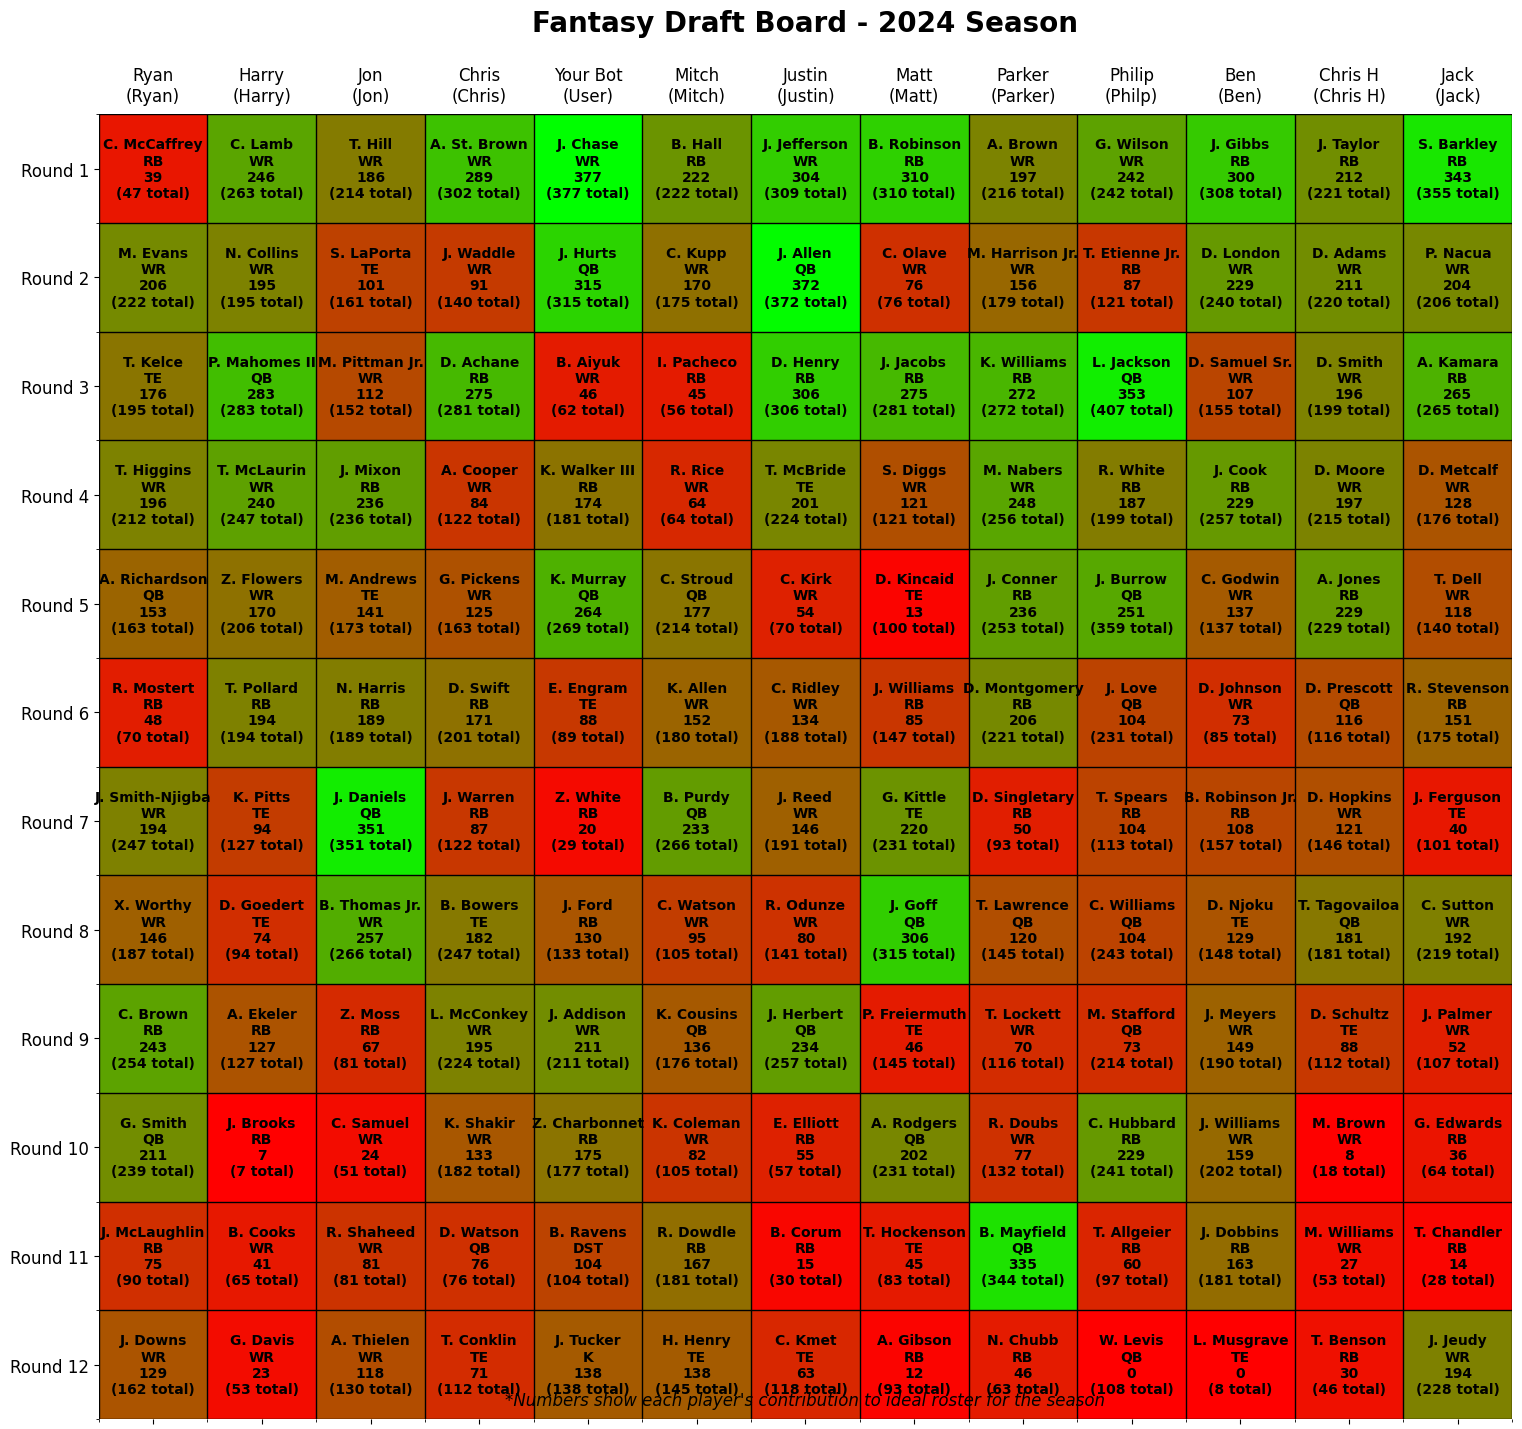

In [3]:
from blitz_env.score_game_sqlite import score_draft_for_visualization

if season < 2025:
    score_draft_for_visualization()

In [8]:

def create_slot_objects(player_slots_dict):
    """Convert player_slots dict to slot objects with allowed_player_positions."""
    class Slot:
        def __init__(self, allowed_positions):
            self.allowed_player_positions = allowed_positions
            self.assigned_player_id = None
    
    slots = []
    for position, count in player_slots_dict.items():
        if position == "FLEX":
            allowed_positions = ["RB", "WR", "TE"]
        elif position == "SUPERFLEX":
            allowed_positions = ["QB", "RB", "WR", "TE"]
        else:
            # Regular positions
            allowed_positions = [position]
        
        for _ in range(count):
            slots.append(Slot(allowed_positions))
    
    return slots

db = DatabaseManager()
settings = db.get_league_settings()
slots = create_slot_objects(settings.player_slots)

sorted_slots = sorted(slots, key=lambda slot: len(slot.allowed_player_positions))
for slot in sorted_slots:
    print(slot.allowed_player_positions)



['QB']
['RB']
['RB']
['WR']
['WR']
['K']
['DST']
['BENCH']
['BENCH']
['BENCH']
['RB', 'WR', 'TE']
['QB', 'RB', 'WR', 'TE']


In [27]:
from blitz_env.models import DatabaseManager
import pandas as pd
from blitz_env.stats_db import StatsDB

def get_points(stats_db, player, year, week):
    df = stats_db.get_weekly_data(player)
    try:
        data_row = df[(df["season"] == year) & (df["week"] == week)]
        if "fantasy_points_ppr" in data_row.columns:
            return data_row["fantasy_points_ppr"].iloc[0]
        else:
            return data_row["FPTS"].iloc[0]
    except IndexError:
        return 0  # Player did not play that week

def get_best_possible_score(stats_db, players, player_slots_dict, year, week):
    player_slots = create_slot_objects(player_slots_dict)
    
    total_score = 0
    used_player_ids = set()
    player_contributions = {}  # New dictionary to track player contributions for the week
    player_points = {}
    for player in players:
        player_points[player.id] = get_points(stats_db, player, year, week)

    # Sort slots by the size of allowed positions (ascending)
    sorted_slots = sorted(player_slots, key=lambda slot: len(slot.allowed_player_positions))

    # Helper function to find the best player for a given slot
    def find_best_player_for_slot(slot):
        best_player = None
        best_points = -float('inf')

        for player in players:
            if player.id not in used_player_ids and any(pos in slot.allowed_player_positions for pos in player.allowed_positions):
                points = player_points[player.id]
                if points > best_points:
                    best_points = points
                    best_player = player

        return best_player, best_points

    print()
    print()

    for slot in sorted_slots:
        print(slot.allowed_player_positions)

    print()
    print()

    # Assign players to slots
    for slot in sorted_slots:
        best_player, best_points = find_best_player_for_slot(slot)
        if best_player:
            print(best_player.full_name)
            print(best_points)
            total_score += best_points
            used_player_ids.add(best_player.id)
            slot.assigned_player_id = best_player.id  # Assign the player to the slot
            # Track the player's contribution
            player_contributions[best_player.id] = player_contributions.get(best_player.id, 0) + best_points
    
    return total_score, player_contributions, player_points


db = DatabaseManager()
stats_db = StatsDB([settings.year], include_k_dst=True)
team_players = [player for player in db.get_all_players() if player.current_bot_id == '8']
for player in team_players:
    print(player.full_name + " : " + ",".join(player.allowed_positions) + " : " + str(get_points(stats_db, player, settings.year, 1)))


settings = db.get_league_settings()
week = 1

best_possible_score, _, _ = get_best_possible_score(
    stats_db, team_players, settings.player_slots, settings.year, week
)




Downcasting floats.
A.J. Brown : WR : 22.9
Marvin Harrison Jr. : WR : 1.4
Kyren Williams : RB : 14.4
Malik Nabers : WR : 11.6
James Conner : RB : 19.3
David Montgomery : RB : 16.3
Devin Singletary : RB : 9.2
Trevor Lawrence : QB : 11.28
Tyler Lockett : WR : 13.7
Romeo Doubs : WR : 9.0
Baker Mayfield : QB : 29.66
Nick Chubb : RB : 0


['QB']
['RB']
['RB']
['WR']
['WR']
['K']
['DST']
['BENCH']
['BENCH']
['BENCH']
['RB', 'WR', 'TE']
['QB', 'RB', 'WR', 'TE']


Baker Mayfield
29.66
James Conner
19.3
David Montgomery
16.3
A.J. Brown
22.9
Tyler Lockett
13.7
Kyren Williams
14.4
Malik Nabers
11.6
